<a href="https://colab.research.google.com/github/riceriii/capstone-bangkit-ml-2024/blob/main/corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [32]:
import cv2
from PIL import Image
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.models.detection.mask_rcnn
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the dataset

In [26]:
# Define your dataset class
class BookCoverDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [27]:
# Load train and test (ICDAR and Synthetic Book Cover) array (size=150x150)
input_path = "/content/drive/MyDrive/Book Cover Segmentation/Processed Data/processed_150"

train_images = np.load(os.path.join(input_path, "Train", "img.npy"))
train_labels = np.load(os.path.join(input_path, "Train", "label.npy"))

test_images = np.load(os.path.join(input_path, "Test", "img.npy"))
test_labels = np.load(os.path.join(input_path, "Test", "label.npy"))

In [28]:
# Create train and test datasets
train_dataset = BookCoverDataset(train_images, train_labels)
test_dataset = BookCoverDataset(test_images, test_labels)

# Create train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

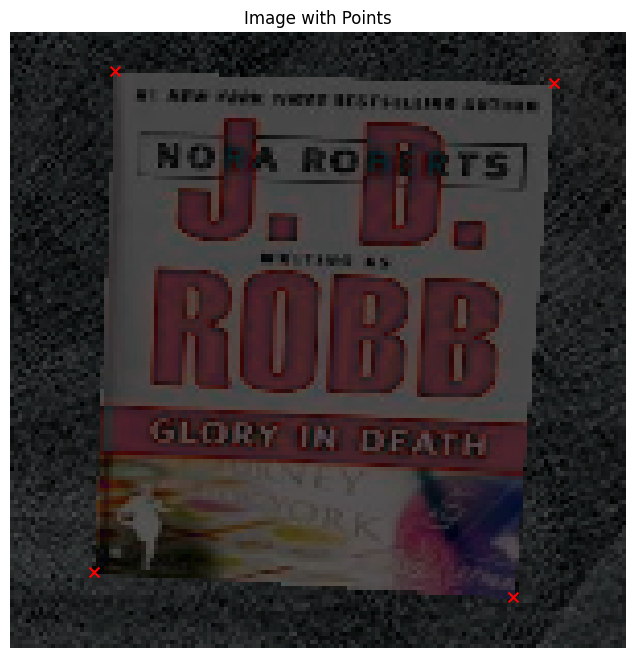

In [30]:
# Function to display image and points
def show_image_with_points(image, points):
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.scatter(points[:, 0], points[:, 1], s=50, c='red', marker='x')
    plt.title('Random Image with Points')
    plt.axis('off')
    plt.show()

# Randomly select an image and its points
random_idx = np.random.randint(len(train_images))  # Assuming train_images contains images
random_image = train_images[random_idx]
random_points = train_labels[random_idx]

# Display the random image with its points
show_image_with_points(random_image, random_points)

## Build the Faster R-CNN model

In [15]:
# Number of classes (including background)
num_classes = 2  # 2 classes (foreground and background)

In [21]:
# Use ResNet-50 backbone
backbone = torchvision.models.resnet50(pretrained=True)

# Modify the backbone to remove the fully connected layer
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])

# Specify the number of output channels for the backbone
backbone.out_channels = 2048  # ResNet-50 has 2048 output channels

In [18]:
# Anchor generator
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

In [19]:
# ROI pooler
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

In [22]:
# Define the model
model = FasterRCNN(backbone,
                    num_classes=num_classes,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)

In [23]:
# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (

In [33]:
# Loss function
class MaskRCNNLoss(torch.nn.Module):
    def __init__(self):
        super(MaskRCNNLoss, self).__init__()

    def forward(self, predictions, targets):
        # Extract predictions and targets
        masks_pred = predictions['masks']
        masks_target = targets['masks']

        # Compute the binary cross-entropy loss
        loss = torch.nn.functional.binary_cross_entropy(masks_pred, masks_target)

        return loss

In [34]:
# Train the model
num_epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
criterion = MaskRCNNLoss()

for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")

AttributeError: 'Tensor' object has no attribute 'items'